# Compile the main simulator code using cython 

In [2]:
!python ../setup.py build_ext --inplace

/home/jyotika/.local/lib/python3.8/site-packages/Cython/Build/Dependencies.py:1025: UserWarning: build_dir has no effect for absolute source paths
  warnings.warn("build_dir has no effect for absolute source paths")
running build_ext
copying build/lib.linux-x86_64-cpython-38/agent_timestep_plasticity.cpython-38-x86_64-linux-gnu.so -> 
running build_ext
copying build/lib.linux-x86_64-cpython-38/agent_timestep_stop_signal.cpython-38-x86_64-linux-gnu.so -> 
/home/jyotika/Work/CBGTPy_release/CBGTPy/notebooks/agent_timestep_plasticity.cpython-38-x86_64-linux-gnu.so
/home/jyotika/Work/CBGTPy_release/CBGTPy/notebooks/agent_timestep_stop_signal.cpython-38-x86_64-linux-gnu.so


# Import all the relevant files 

In [5]:
# Import the pipeline creation object
import sys
sys.path.append('../')

# Import the pipeline creation object
import pandas as pd
import numpy as np
import common.cbgt as cbgt
import common.pipeline_creation as pl_creat
import common.plotting_functions as plt_func
import common.plotting_helper_functions as plt_help
import common.postprocessing_helpers as post_help
import importlib

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)


%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

In [7]:
# Choose the experiment:
experiment_choice = 'n-choice'

if experiment_choice == 'stop-signal':
    import stopsignal.paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import nchoice.paramfile_nchoice as paramfile

number_of_choices = 3

#Choose which multiprocessing library to use
use_library = "pathos" # "none" or "pathos" or "ray"

# Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

# how many simulations do you want to run ? each simulation is executed as a seperate thread
num_sims = 1
num_cores = 7
# set a seed
import time
np.random.seed(int(time.time()))
#seed = np.random.choice(np.random.randint(0,9999999,100),1)[0]
seed = 8867366
print(seed)


in choose pipeline
in reward pipeline
8867366


In [9]:

# Define the data and figure directory

data_dir = "../Data/"
figure_dir = "../Figures/"



# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [10]:
# list out the available parameter dictionaries
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [11]:
# view (or edit) one of the parameter dictionaries
paramfile.celldefaults

{'N': 75,
 'C': 0.5,
 'Taum': 20,
 'RestPot': -70,
 'ResetPot': -55,
 'Threshold': -50,
 'RestPot_ca': -85,
 'Alpha_ca': 0.5,
 'Tau_ca': 80,
 'Eff_ca': 0.0,
 'tauhm': 20,
 'tauhp': 100,
 'V_h': -60,
 'V_T': 120,
 'g_T': 0,
 'g_adr_max': 0,
 'Vadr_h': -100,
 'Vadr_s': 10,
 'ADRRevPot': -90,
 'g_k_max': 0,
 'Vk_h': -34,
 'Vk_s': 6.5,
 'tau_k_max': 8,
 'n_k': 0,
 'h': 1}

# Running the pipeline

### 1. Default values of environment variable

In [12]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None, # default = 600ms
    'thalamic_threshold': None, # default 30sp/s
    'movement_time':None,# #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout':None, #wait for a choice to be made, default 1000, 
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([["A"],["B"],["C"]], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' :None,
    'Q_support_params': None,#pd.DataFrame([[85,0.6]],columns=['dpmn_CPP_scale','q_alpha']), #initialization of Q-values update (qvalues.py) 
    'Q_df_set':pd.DataFrame([[0.5, 0.5,0.5]],columns=["A","B","C"]), #initialized Q-values df (qvalues.py)  
    'n_trials': 3, #number of trials (generateepochs.py)
    'volatility': [1,"exact"], #frequency of changepoints and type of change points (exact or poisson) (generateepochs.py)
    'conflict': (0.7, 0.3,0.4), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.01, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # 3 instead? how much stimulus the LIP gets at maximum
    'corticostriatal_plasticity_present':False, # whether plasticity is on or "off" at corticostriatal synapses
    'record_variables':["weight","optogenetic_input"],#"optogenetic_input"],
    'opt_signal_present':[True, True],
    'opt_signal_probability':[[0],[1]], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude':[0.1, -0.5], # ampitude of the stop signal over base line
    'opt_signal_onset':[10.,10.], # in ms
    'opt_signal_duration':["phase 0",400.],
    'opt_signal_channel': ["all","all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["iSPN","dSPN"],
    'sustainedfraction':0.7
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}


### Run the simulation - num_sims thread with the environment variable

In [13]:
# pl.modulelist

In [14]:
results = cbgt.ExecutionManager(cores=num_cores,use=use_library).run([pl]*num_sims,[configuration]*num_sims)


in choose pipeline
SpawnThreadManagers <common.backend.Pipeline object at 0x7f1b1276f910>
change points: [0 1 2 2]
conflict (0.7, 0.3, 0.4)
conflict (0.7, 0.3, 0.4)
sum 1.4
n_prob_trials [0, 0, 0]
calc_rew      A    B    C
0  0.0  0.0  0.0
reward_list      A    B    C
0  0.0  0.0  0.0
conflict (0.7, 0.3, 0.4)
sum 1.4
n_prob_trials [0, 0, 0]SpawnThreadManagers <common.backend.Pipeline object at 0x7f1b127781f0>

calc_rew      B    C    A
0  0.0  0.0  0.0
reward_list      B    C    A
0  0.0  0.0  0.0
scaling_conn 0.6666666666666666
scaling_wts 1
begin GenOptSchedule
<class 'list'>
[0]
pop i
True
pop S
True
pop P
True
pop N
True
<class 'list'>
[1]
pop d
True
pop S
True
pop P
True
pop N
True
opt_amplitude_dfs [     A    B    C  trial_num
0  0.1  0.1  0.1          0
1  0.1  0.1  0.1          1
2  0.1  0.1  0.1          2,      A    B    C  trial_num
0 -0.5 -0.5 -0.5          0
1 -0.5 -0.5 -0.5          1
2 -0.5 -0.5 -0.5          2]
opt_df
   opt_signal_present opt_signal_probability opt_sig

In [15]:
# List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'corticostriatal_plasticity_present', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'sustainedfraction', 'par', 'popconstruct', 'interface', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'opt_df', 'opt_channels_dfs', 'opt_amplitude_dfs', 'opt_onset_dfs', 'opt_duration_dfs', 'opt_populations_df

In [16]:
results[0]['meaneff_GABA']

,GPi,GPi,GPi,STN,STN,STN,GPe,GPe,GPe,dSPN,...,iSPN,iSPN,Cx,Cx,Cx,Th,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.058`,0.0`,0.0`,0.35`,0.0`,0.0`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.0`,0.058`,0.0`,0.0`,0.35`,0.0`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.0`,0.0`,0.058`,0.0`,0.0`,0.35`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,2.09`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.28`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [17]:
results[0]['conflict']

(0.7, 0.3, 0.4)

In [18]:
results[0]['Q_df']

,A,B,C
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5


In [19]:
experiment_choice

'n-choice'

In [20]:
#Extract all the relevant dataframes
firing_rates, reward_q_df, performance, rt_dist, total_performance = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [21]:
results[0]['popfreqs']

,GPi_A,GPi_B,GPi_C,STN_A,STN_B,STN_C,GPe_A,GPe_B,GPe_C,dSPN_A,...,iSPN_C,Cx_A,Cx_B,Cx_C,Th_A,Th_B,Th_C,FSI_common,CxI_common,Time (ms)
0,58.888889,63.777778,68.222222,25.222222,26.800000,27.000000,61.466667,61.977778,58.177778,6.666667,...,6.000000,0.000000,0.000000,0.000000,10.666667,8.222222,9.111111,8.222222,0.806452,0
1,58.666667,64.222222,67.777778,25.400000,26.488889,26.844444,61.666667,62.066667,58.822222,6.222222,...,5.777778,0.000000,0.000000,0.000000,10.000000,8.222222,9.333333,8.000000,0.806452,1
2,58.888889,63.777778,68.444444,25.177778,26.288889,27.022222,62.444444,61.955556,58.866667,6.222222,...,6.000000,0.000000,0.000000,0.000000,10.222222,7.777778,9.111111,8.444444,0.806452,2
3,59.111111,62.666667,68.666667,25.400000,26.133333,27.111111,62.688889,61.644444,58.955556,5.555556,...,5.777778,0.000000,0.000000,0.000000,10.000000,7.777778,9.111111,8.444444,0.716846,3
4,60.666667,61.777778,68.888889,25.288889,26.133333,27.088889,63.422222,61.311111,58.733333,5.333333,...,6.222222,0.000000,0.000000,0.000000,9.777778,8.000000,9.333333,8.444444,0.716846,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,65.777778,65.777778,65.111111,25.822222,24.800000,27.111111,59.333333,63.822222,57.000000,4.888889,...,7.555556,0.653595,0.408497,1.062092,9.111111,9.111111,10.444444,8.888889,1.523297,4242
4243,66.000000,67.111111,64.666667,25.977778,24.844444,27.022222,59.533333,63.800000,57.244444,4.888889,...,7.555556,0.653595,0.408497,1.062092,9.111111,9.111111,10.444444,8.888889,1.433692,4243
4244,66.222222,67.111111,64.000000,26.022222,24.733333,27.155556,60.044444,63.822222,56.866667,4.888889,...,7.555556,0.653595,0.408497,1.062092,9.555556,8.888889,10.444444,9.111111,1.433692,4244
4245,66.444444,66.444444,64.444444,25.888889,24.800000,26.977778,60.644444,63.622222,56.711111,4.888889,...,7.333333,0.653595,0.326797,1.062092,9.333333,8.666667,10.222222,9.111111,1.344086,4245


In [22]:
# firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed,n_trials,volatility,volatility_type,conflict
0,0,GPi_A,58.888889,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
1,1,GPi_A,58.666667,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
2,2,GPi_A,58.888889,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
3,3,GPi_A,59.111111,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
4,4,GPi_A,60.666667,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
...,...,...,...,...,...,...,...,...,...,...
97676,4242,CxI_common,1.523297,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
97677,4243,CxI_common,1.433692,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
97678,4244,CxI_common,1.433692,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
97679,4245,CxI_common,1.344086,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"


In [23]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,33.333333,none,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,0.0,33.333333,A,B,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,0.0,33.333333,B,C,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [24]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['A' 'B' 'C']
nuc_list ['dSPN-A' 'iSPN-A' 'dSPN-B' 'iSPN-B' 'dSPN-C' 'iSPN-C']
ind_list [[0 0 1 0 2 0]
 [0 1 1 1 2 1]]


In [25]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.015,0,dSPN-A,8867366_0
1,0.015,1,dSPN-A,8867366_0
0,0.015,0,iSPN-A,8867366_0
1,0.015,1,iSPN-A,8867366_0
0,0.015,0,dSPN-B,8867366_0
1,0.015,1,dSPN-B,8867366_0
0,0.015,0,iSPN-B,8867366_0
1,0.015,1,iSPN-B,8867366_0
0,0.015,0,dSPN-C,8867366_0
1,0.015,1,dSPN-C,8867366_0


In [26]:
recorded_variables['optogenetic_input'].nuclei.unique()

array(['iSPN-A', 'iSPN-B', 'iSPN-C', 'dSPN-A', 'dSPN-B', 'dSPN-C'],
      dtype=object)

In [27]:
recorded_variables['optogenetic_input']

,index,value,nuclei,Time(ms),seed
0,0,1.4,iSPN-A,0,8867366_0
1,1,1.4,iSPN-A,1,8867366_0
2,2,1.4,iSPN-A,2,8867366_0
3,3,1.4,iSPN-A,3,8867366_0
4,4,1.4,iSPN-A,4,8867366_0
...,...,...,...,...,...
25471,4241,1.3,dSPN-C,4241,8867366_0
25472,4242,1.3,dSPN-C,4242,8867366_0
25473,4243,1.3,dSPN-C,4243,8867366_0
25474,4244,1.3,dSPN-C,4244,8867366_0


<AxesSubplot:xlabel='trials', ylabel='weights'>

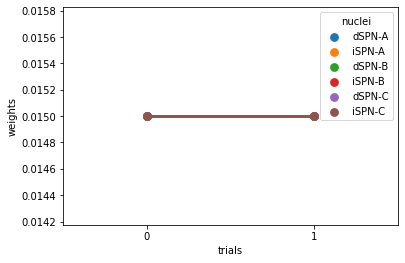

In [28]:
import seaborn as sns
import pylab as pl
sns.pointplot(x="trials",y="weights",hue="nuclei",data=recorded_variables['weight'])


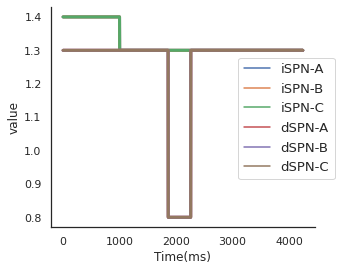

In [39]:
fig,ax = pl.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei',lw=3.0,ax=ax)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right',bbox_to_anchor=[1.1, 0.8])
pl.tight_layout()
fig.savefig(figure_dir+'optogenetic_stimulation.png')


In [40]:
# Relevant reward_dataframe
reward_q_df[0]

,level_0,index,Trials,variable,value,data_type,seed,n_trials,volatility,volatility_type,conflict,condition
0,0,4,0,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,1,5,1,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,2,6,2,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
3,3,7,3,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
4,4,8,0,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
5,5,9,1,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
6,6,10,2,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
7,7,11,3,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
8,8,12,0,C,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
9,9,13,1,C,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [41]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,33.333333,none,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,0.0,33.333333,A,B,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,0.0,33.333333,B,C,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [42]:
# Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]["decisiondurationplusdelay"]-datatables[0]["decisionduration"]

0    249
1    253
2    252
dtype: object

In [43]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,none,0,1001,1001,1250,1250,A,0
1,A,1851,2366,515,768,2619,B,0
2,B,3220,3393,173,425,3645,C,0


In [44]:
# Check the Q-values data frame
results[0]['Q_df']

,A,B,C
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5


In [45]:
# postfix = "weak_GPi_inh"
postfix = ""

In [46]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+postfix+'_'+str(seed)+'.pickle',['popfreqs','popdata','Q_support_params','d1','d2','dpmns','datatables'])


In [47]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
reward_q_df[0].to_csv(data_dir+"reward_df_"+postfix+".csv")
performance.to_csv(data_dir+"performance_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")
total_performance.to_csv(data_dir+"total_performance_"+postfix+".csv")

In [48]:
reward_q_df

[    level_0  index  Trials variable  value      data_type       seed  \
 0         0      4       0        A    0.5           Q_df  8867366_0   
 1         1      5       1        A    0.5           Q_df  8867366_0   
 2         2      6       2        A    0.5           Q_df  8867366_0   
 3         3      7       3        A    0.5           Q_df  8867366_0   
 4         4      8       0        B    0.5           Q_df  8867366_0   
 5         5      9       1        B    0.5           Q_df  8867366_0   
 6         6     10       2        B    0.5           Q_df  8867366_0   
 7         7     11       3        B    0.5           Q_df  8867366_0   
 8         8     12       0        C    0.5           Q_df  8867366_0   
 9         9     13       1        C    0.5           Q_df  8867366_0   
 10       10     14       2        C    0.5           Q_df  8867366_0   
 11       11     15       3        C    0.5           Q_df  8867366_0   
 12        0      0       0        A    0.0      re

In [49]:
results[0]['opt_list_trials_list'][1]

[1]

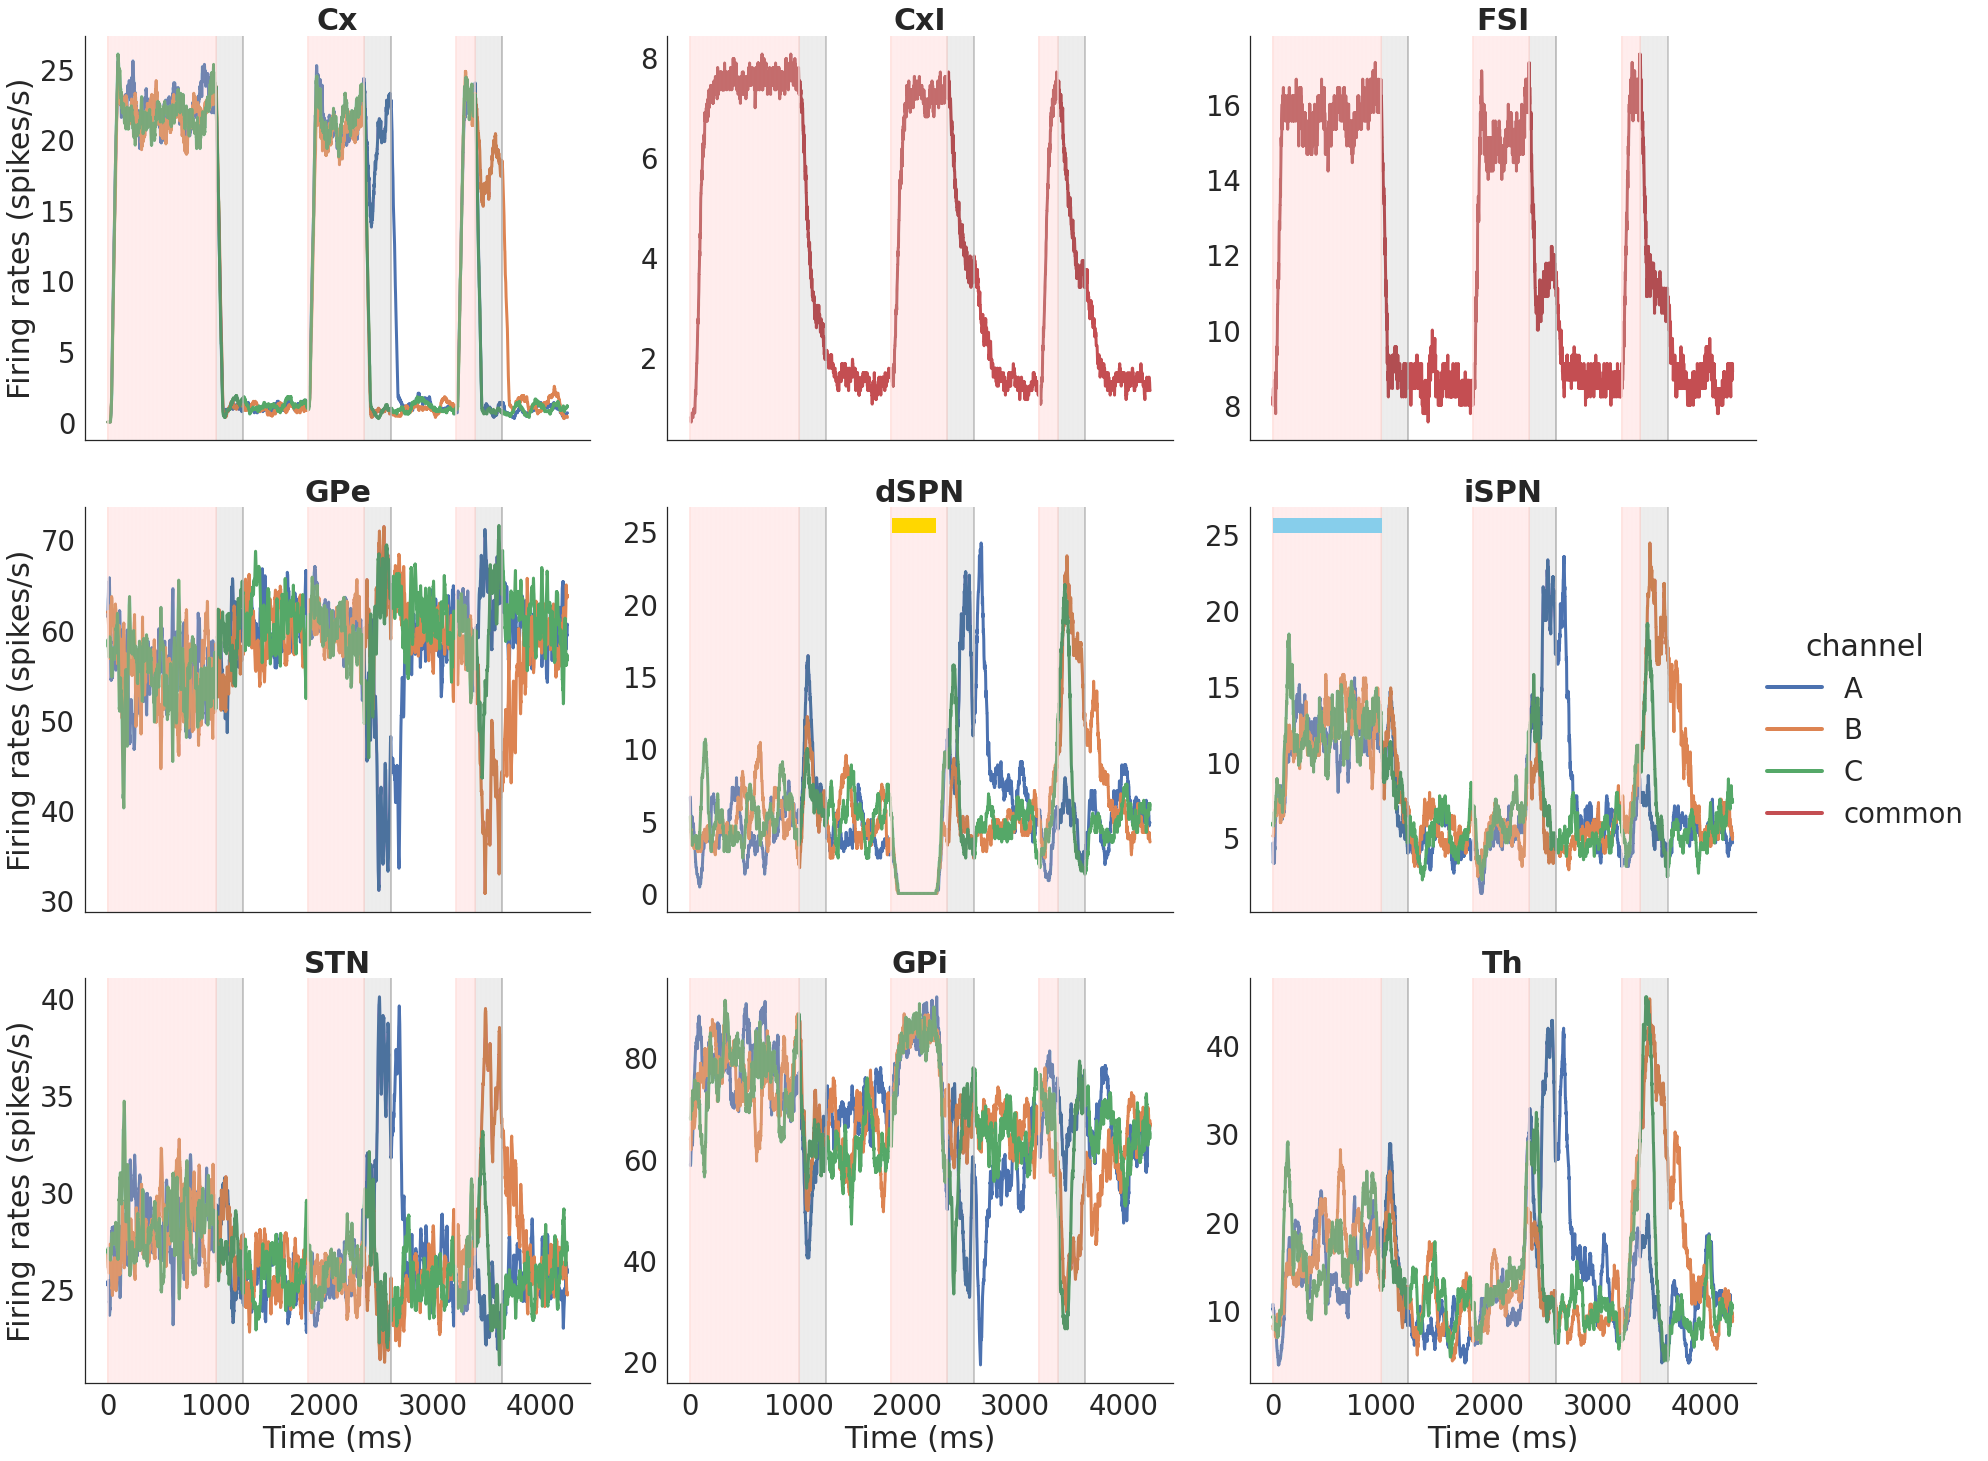

In [50]:
# Plot the firing rates extracted, figure handles are returned in fig_handles

FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_optostim_"+postfix+"two_stims.png",dpi=300)

{'A': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 'B': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), 'C': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), 'none': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)}


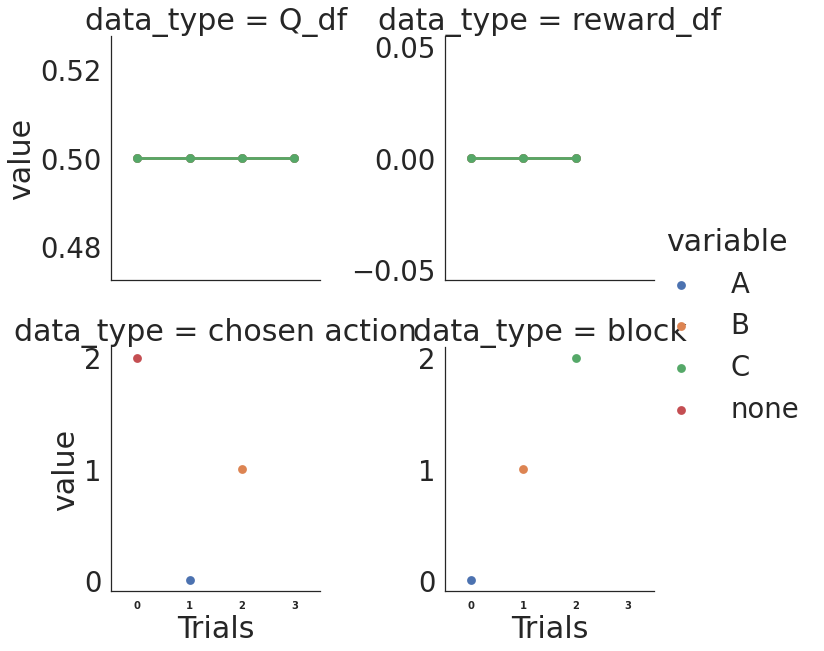

In [51]:
reward_fig_handles = plt_func.plot_reward_Q_df(reward_q_df)